In [2]:
library(ggplot2)
library(reshape2)
library(pander)
library(DESeq2)
library(TxDb.Hsapiens.UCSC.hg19.knownGene)
library("org.Hs.eg.db")
### pathway analysis
library(clusterProfiler)
library("clusterProfiler")
library(enrichplot)
library(pathview)
library(pheatmap)
library("ChIPseeker")

### Read in Count matrix

In [3]:
merged_peaks <- read.table('../00_Analysis/01_peaks/called_Peaks_by_Xie_with_MACS2/merge_peaks.bed',header=FALSE)
rownames(merged_peaks) <-  merged_peaks$V4

In [4]:
df = read.csv('../00_Analysis/04_DEGs/PHH_peaks_Counts.csv',row.names=1,check.names = FALSE)
si = read.csv('../00_Analysis/samp_annot.csv')
si = si[colnames(df),]
si$celltype = factor(si$celltype)
pander(dim(df), "Data dimensions")
head(df,2)

_514880_ and _8_

,a-Hep_12-1,a-Hep_12-2,f-Hep,f-iHep-1,m8,m9,PHH1,PHH2
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
peak1,27,27,38,45,36,39,27,48
peak2,1,4,4,5,16,19,13,4


In [5]:
# remove all the rows where not a single sample has more than 50 reads (all sample has less than 50 reads).
df = df[apply(df[,1:ncol(df)], 1, max) > 30,]
dim(df)

[1] 239375      8

In [6]:
counts = df[,1:ncol(df)]
dds = DESeqDataSetFromMatrix(countData = counts, colData = si, design = ~ celltype)
dds = DESeq(dds)

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning 

In [7]:
dds_vst <- vst(dds, blind=TRUE) #
head(assay(dds_vst),1)

,a-Hep_12-1,a-Hep_12-2,f-Hep,f-iHep-1,m8,m9,PHH1,PHH2
peak1,4.842607,4.925368,5.455757,5.097426,5.680365,5.718091,5.66442,6.531899


### DE Peaks

In [123]:
### identify differential peaks between a-Hep and f-Hep.
res = results(dds, lfcThreshold=0, contrast=c("celltype", "a-Hep", "f-Hep"))
print(mcols(res, use.names=T))

### assign value of 1st group
baseA <- assay(dds_vst)[, colData(dds)$celltype == "a-Hep"]
if (is.vector(baseA)){
    baseMeanA <- as.data.frame(baseA)
} else {
    baseMeanA <- as.data.frame(rowMeans(baseA))
}
colnames(baseMeanA) <- sampleA

### assign value of 2nd group
baseB <- assay(dds_vst)[, colData(dds)$celltype == "f-Hep"]
if (is.vector(baseB)){
        baseMeanB <- as.data.frame(baseB)
} else {
        baseMeanB <- as.data.frame(rowMeans(baseB))
}
colnames(baseMeanB) <- sampleB

### cbind
res <- cbind(baseMeanA, baseMeanB, as.data.frame(res))
dim(res)
head(res,2)

DataFrame with 6 rows and 2 columns
                       type            description
                <character>            <character>
baseMean       intermediate mean of normalized c..
log2FoldChange      results log2 fold change (ML..
lfcSE               results standard error: cell..
stat                results Wald statistic: cell..
pvalue              results Wald test p-value: c..
padj                results   BH adjusted p-values


[1] 239375      8

,a-Hep,f-Hep,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
peak1,4.883988,5.276591,38.528991,-0.5368986,0.5748038,-0.9340555,0.3502753,0.5259947
peak3,3.916663,4.194883,8.321337,-0.8098176,1.1754291,-0.6889549,0.4908517,0.6535503


In [124]:
# write.table(res, 'aHep-vs-fHep_peaks_DESeq2_2022.txt')

up and dn peaks in ahep

In [125]:
up_in_ahep <- dplyr::filter(res, log2FoldChange >= 1 & padj < 0.05)
down_in_ahep <- dplyr::filter(res, log2FoldChange <= (-1) & padj < 0.05)
dim(up_in_ahep)
dim(down_in_ahep)

[1] 30222     8

[1] 22400     8

#### PHH-vs-f-Hep

In [126]:
phh_vs_fHep_res = results(dds, lfcThreshold=0, contrast=c("celltype", "PHH", "f-Hep"))
### assign value of 1st group
baseA <- assay(dds_vst)[, colData(dds)$celltype == "PHH"]
if (is.vector(baseA)){
    baseMeanA <- as.data.frame(baseA)
} else {
    baseMeanA <- as.data.frame(rowMeans(baseA))
}
colnames(baseMeanA) <- "PHH"

### assign value of 2nd group
baseB <- assay(dds_vst)[, colData(dds)$celltype == "f-Hep"]
if (is.vector(baseB)){
        baseMeanB <- as.data.frame(baseB)
} else {
        baseMeanB <- as.data.frame(rowMeans(baseB))
}
colnames(baseMeanB) <- "f-Hep"

### cbind
phh_vs_fHep_res <- cbind(baseMeanA, baseMeanB, as.data.frame(phh_vs_fHep_res))
dim(phh_vs_fHep_res)
head(phh_vs_fHep_res,2)

[1] 239375      8

,PHH,f-Hep,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
peak1,6.098159,5.276591,38.528991,1.0678971,0.5649909,1.8901139,0.05874273,0.1399716
peak3,4.235687,4.194883,8.321337,-0.1532873,1.1933224,-0.1284543,0.89778950,0.9415174


In [127]:
# write.table(phh_vs_fHep_res, 'phh-vs-fHep_peaks_DESeq2_2022.txt')

In [128]:
up_in_phh <- dplyr::filter(phh_vs_fHep_res, log2FoldChange >= 1 & padj < 0.05)
down_in_phh <- dplyr::filter(phh_vs_fHep_res, log2FoldChange <= (-1) & padj < 0.05)
dim(up_in_phh)
dim(down_in_phh)

[1] 32748     8

[1] 36373     8

##### Overlap

In [129]:
library('VennDiagram')

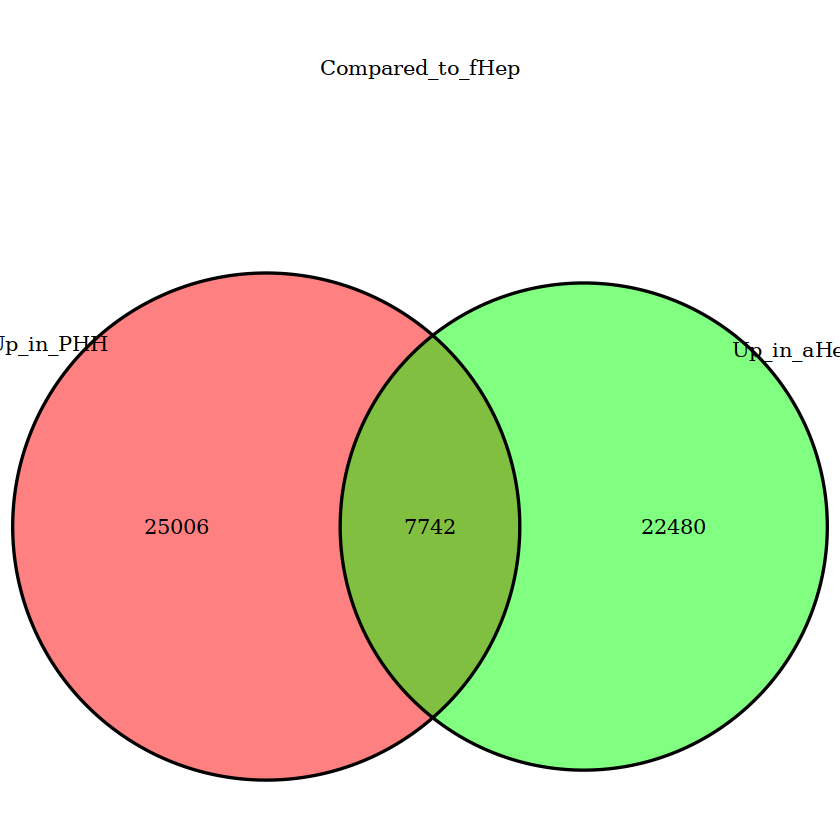

In [130]:
v1 <- venn.diagram(x = list(A= rownames(up_in_phh), 
                            B=rownames(up_in_ahep)),
                     fill = c("red", "green"), alpha = c(0.5, 0.5),
                     category.names = c("Up_in_PHH" , "Up_in_aHep"),
                   main='Compared_to_fHep',filename=NULL)
grid.draw(v1)

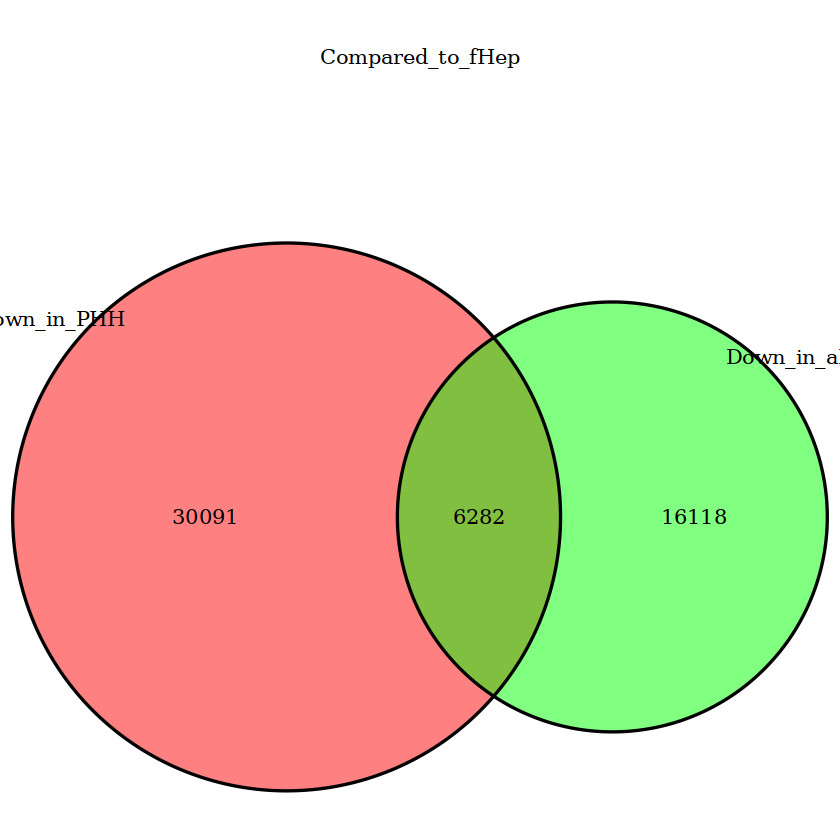

In [131]:
v2 <- venn.diagram(x = list(A= as.character(rownames(down_in_phh)), 
                            B=as.character(rownames(down_in_ahep))),
                     fill = c("red", "green"), alpha = c(0.5, 0.5),
                     category.names = c("Down_in_PHH" , "Down_in_aHep"),
                   main='Compared_to_fHep',filename=NULL)
grid.draw(v2)

### Peak Annot

In [202]:
df <-  down_in_phh#up_in_phh, up_in_ahep, down_in_ahep

In [203]:
df$chr <- merged_peaks[rownames(df),]$V1
df$start <- merged_peaks[rownames(df),]$V2
df$end <- merged_peaks[rownames(df),]$V3

In [204]:
gr = makeGRangesFromDataFrame(df, keep.extra.columns=T)
peakAnno = annotatePeak(gr, tssRegion=c(-2000, 2000), TxDb=TxDb.Hsapiens.UCSC.hg19.knownGene,
                       annoDb="org.Hs.eg.db")
peakAnno_df <- as.data.frame(peakAnno@anno)

>> preparing features information...		 2022-10-21 05:40:41 PM 
>> identifying nearest features...		 2022-10-21 05:40:41 PM 
>> calculating distance from peak to TSS...	 2022-10-21 05:40:42 PM 
>> assigning genomic annotation...		 2022-10-21 05:40:42 PM 
>> adding gene annotation...			 2022-10-21 05:40:44 PM 


'select()' returned 1:many mapping between keys and columns



>> assigning chromosome lengths			 2022-10-21 05:40:44 PM 
>> done...					 2022-10-21 05:40:44 PM 


In [186]:
# options(repr.plot.width = 10, repr.plot.height = 6)
# plotAnnoPie(peakAnno)

##### Pathway analysis

In [205]:
promoter_peaks <- peakAnno_df[grep(pattern = paste(c("Promoter"),collapse="|"), #"1st Exon","1st Intron","UTR"
                                       peakAnno_df[,'annotation']),]
dim(promoter_peaks)
original_gene_list <- promoter_peaks$SYMBOL
ids<-bitr(original_gene_list, fromType = "SYMBOL", toType = "ENTREZID", OrgDb="org.Hs.eg.db")
dedup_ids = ids[!duplicated(ids[c("SYMBOL")]),]
dim(dedup_ids)

[1] 4615   25

'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(original_gene_list, fromType = "SYMBOL", toType = "ENTREZID", :
“0.03% of input gene IDs are fail to map...”


[1] 3557    2

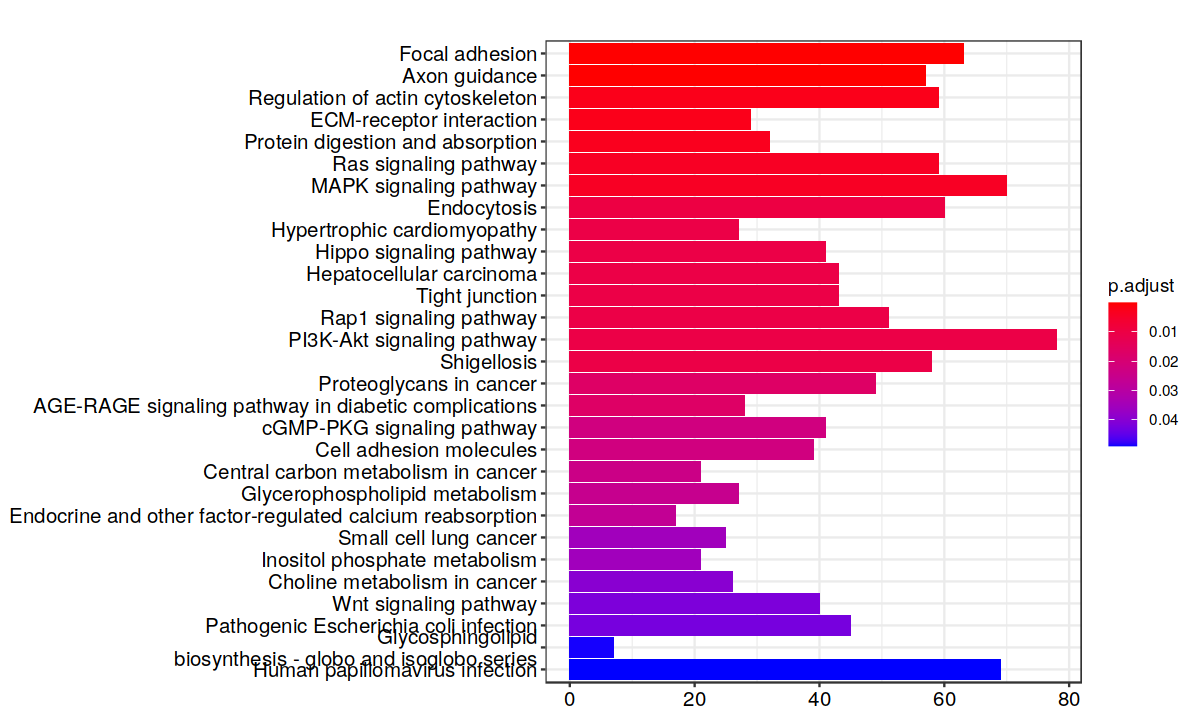

In [194]:
kegg_organism = "hsa"
kk2 <- enrichKEGG(gene = dedup_ids$ENTREZID, organism = kegg_organism,pvalueCutoff = 0.05, minGSSize = 10)
#kk2 <- enrichGO(gene = dedup_ids$ENTREZID, 'org.Hs.eg.db',pvalueCutoff = 0.05, minGSSize = 5)
barplot(kk2, showCategory=50)
#write.csv(as.data.frame(kk2),'atac_a-vs-f_up_go.csv')

### Heatmap

In [2]:
library(EnrichedHeatmap)
library(rtracklayer)
library(circlize)

In [10]:
deg <- read.table('aHep-vs-fHep_peaks_DESeq2_2022.txt')
peaks <- dplyr::filter(deg, log2FoldChange <= (-1) & padj < 0.01)

In [6]:
ExtendSize <- 2000
targets <- GRanges(seqnames = peaks$chr,
                  ranges = IRanges(start = round((peaks$start+peaks$end)/2)),
                  mcols = rownames(peaks))
targets.extended  <- resize(targets, fix = "center", width = ExtendSize*2)

In [7]:
BigWig <- rtracklayer::import("./01_peaks/a-Hep_12-1_q10_rdup_sort.SeqDepthNorm.bw", 
                              format = "BigWig", 
                              selection = BigWigSelection(targets.extended))
mat1 <- normalizeToMatrix(signal = BigWig, 
                                target = resize(targets, fix = "center", width = 1), 
                                background = 0, 
                                keep = c(0, 0.99),      #/ minimal value to the 99th percentile
                                target_ratio = 0,
                                mean_mode = "w0",       #/ see ?EnrichedHeatmap on other options
                                value_column = "score", #/ = the name of the 4th column of the bigwig
                                extend = ExtendSize)

In [8]:
BigWig <- rtracklayer::import("./01_peaks/f-Hep_q10_rdup_sort.SeqDepthNorm.bw", 
                              format = "BigWig", 
                              selection = BigWigSelection(targets.extended))
mat2 <- normalizeToMatrix(signal = BigWig, 
                                target = resize(targets, fix = "center", width = 1), 
                                background = 0, 
                                keep = c(0, 0.99),      #/ minimal value to the 99th percentile
                                target_ratio = 0,
                                mean_mode = "w0",       #/ see ?EnrichedHeatmap on other options
                                value_column = "score", #/ = the name of the 4th column of the bigwig
                                extend = ExtendSize)

In [11]:
BigWig <- rtracklayer::import("./01_peaks/PHH1_q10_rdup_sort.SeqDepthNorm.bw", 
                              format = "BigWig", 
                              selection = BigWigSelection(targets.extended))
mat3_ <- normalizeToMatrix(signal = BigWig, 
                                target = resize(targets, fix = "center", width = 1), 
                                background = 0, 
                                keep = c(0, 0.99),      #/ minimal value to the 99th percentile
                                target_ratio = 0,
                                mean_mode = "w0",       #/ see ?EnrichedHeatmap on other options
                                value_column = "score", #/ = the name of the 4th column of the bigwig
                                extend = ExtendSize)

In [ ]:
BigWig <- rtracklayer::import("./01_peaks/PHH2_q10_rdup_sort.SeqDepthNorm.bw", 
                              format = "BigWig", 
                              selection = BigWigSelection(targets.extended))
mat3__ <- normalizeToMatrix(signal = BigWig, 
                                target = resize(targets, fix = "center", width = 1), 
                                background = 0, 
                                keep = c(0, 0.99),      #/ minimal value to the 99th percentile
                                target_ratio = 0,
                                mean_mode = "w0",       #/ see ?EnrichedHeatmap on other options
                                value_column = "score", #/ = the name of the 4th column of the bigwig
                                extend = ExtendSize)

In [13]:
mat3 <- (mat3_+mat3__)/2 
rm(mat3_)
rm(mat3__)

In [12]:
BigWig <- rtracklayer::import("./01_peaks/m8-Hep_q10_rdup_sort.SeqDepthNorm.bw", 
                              format = "BigWig", 
                              selection = BigWigSelection(targets.extended))
mat4 <- normalizeToMatrix(signal = BigWig, 
                                target = resize(targets, fix = "center", width = 1), 
                                background = 0, 
                                keep = c(0, 0.99),      #/ minimal value to the 99th percentile
                                target_ratio = 0,
                                mean_mode = "w0",       #/ see ?EnrichedHeatmap on other options
                                value_column = "score", #/ = the name of the 4th column of the bigwig
                                extend = ExtendSize)

In [13]:
color='skyblue3' #skyblue3, 'royalblue'
col_fun = colorRamp2(quantile(as.matrix(mat2), c(0, 0.96)), c("white", color))

In [18]:
ymax <- 30
#/ heatmap function:
EH <- EnrichedHeatmap( mat = mat2, 
                       pos_line = FALSE, #/ no dashed lines around the start
                       border = TRUE,   #/ no box around heatmap
                       col = col_fun,    #/ color gradients from above
                       column_title = "f-Hep", #/ column title 
                       column_title_gp = gpar(fontsize = 15, fontfamily = "sans"),
                       use_raster = FALSE, #raster_quality = 10, raster_device = "png",
                       #/ turn off background colors
                       rect_gp = gpar(col = "transparent"), 
                       #/ legend options:
                       heatmap_legend_param = list(
                         legend_direction = "horizontal",
                         title = "normalized counts"),
                       #/ options for the profile plot on top of the heatmap:
                       top_annotation = HeatmapAnnotation(
                         enriched = anno_enriched(
                             yaxis = FALSE,
                            ylim=c(0,ymax),
                           gp = gpar(col = "black", lty = 1, lwd=2),
                           col="black")
                       )
                      ) +
EnrichedHeatmap( mat = mat4, 
                       pos_line = FALSE, #/ no dashed lines around the start
                       border = TRUE,   #/ no box around heatmap
                       col = col_fun,    #/ color gradients from above
                       column_title = "m-Hep", #/ column title 
                       column_title_gp = gpar(fontsize = 15, fontfamily = "sans"),
                       use_raster = FALSE, #raster_quality = 10, raster_device = "png",
                       #/ turn off background colors
                       rect_gp = gpar(col = "transparent"), 
                       #/ legend options:
                       heatmap_legend_param = list(
                         legend_direction = "horizontal",
                         title = "normalized counts"),
                       #/ options for the profile plot on top of the heatmap:
                       top_annotation = HeatmapAnnotation(
                         enriched = anno_enriched(
                             yaxis = FALSE,
                            ylim=c(0,ymax),
                           gp = gpar(col = "black", lty = 1, lwd=2),
                           col="black")
                       )
                      ) + 
EnrichedHeatmap( mat = mat1, 
                       pos_line = FALSE, #/ no dashed lines around the start
                       border = TRUE,   #/ no box around heatmap
                       col = col_fun,    #/ color gradients from above
                       column_title = "a-Hep", #/ column title 
                       column_title_gp = gpar(fontsize = 15, fontfamily = "sans"),
                       use_raster = FALSE, #raster_quality = 10, raster_device = "png",
                       #/ turn off background colors
                       rect_gp = gpar(col = "transparent"), 
                       #/ legend options:
                       heatmap_legend_param = list(
                         legend_direction = "horizontal",
                         title = "normalized counts"),
                       #/ options for the profile plot on top of the heatmap:
                       top_annotation = HeatmapAnnotation(
                         enriched = anno_enriched(
                             yaxis = FALSE,
                             ylim=c(0,ymax),
                           gp = gpar(col = "black", lty = 1, lwd=2),
                           col="black")
                       )
                      ) + 
EnrichedHeatmap( mat = mat3_, 
                       pos_line = FALSE, #/ no dashed lines around the start
                       border = TRUE,   #/ no box around heatmap
                       col = col_fun,    #/ color gradients from above
                       column_title = "PHH", #/ column title 
                       column_title_gp = gpar(fontsize = 15, fontfamily = "sans"),
                       use_raster = FALSE, #raster_quality = 10, raster_device = "png",
                       #/ turn off background colors
                       rect_gp = gpar(col = "transparent"), 
                       #/ legend options:
                       heatmap_legend_param = list(
                         legend_direction = "horizontal",
                         title = "normalized counts"),
                       #/ options for the profile plot on top of the heatmap:
                       top_annotation = HeatmapAnnotation(
                         enriched = anno_enriched(
                             yaxis = FALSE,
                             ylim=c(0,ymax),
                           gp = gpar(col = "black", lty = 1, lwd=2),
                           col="black")
                       )
                      )

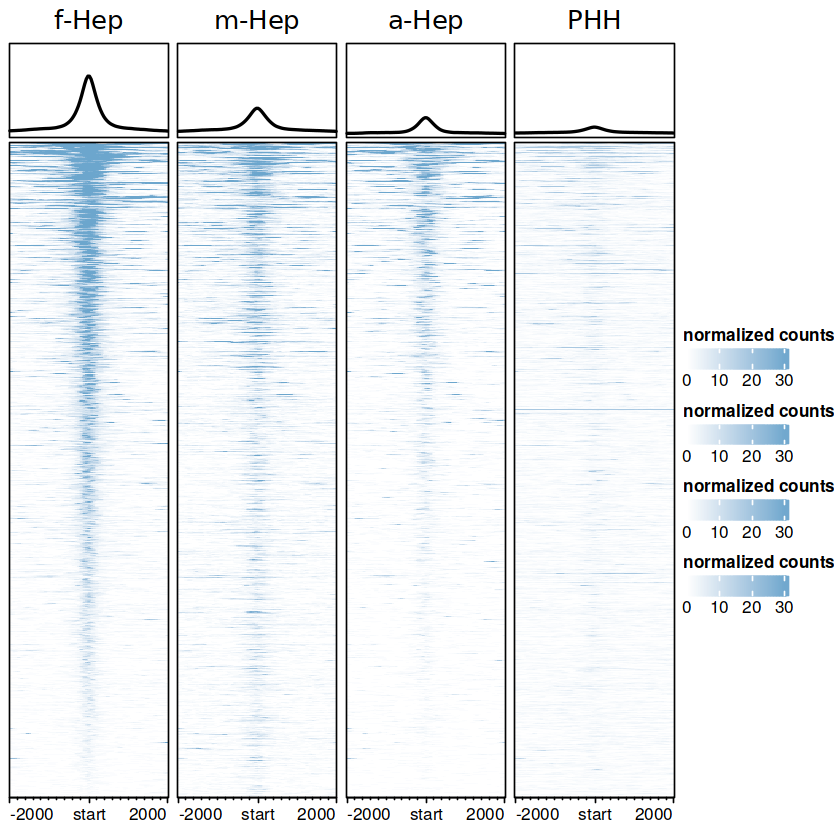

In [19]:
EH

In [20]:
pdf('./05_Heatmap/Figs/peaks_aHepvsfHep-down_heatmap_skyblue3.pdf',width=5, height=4)
EH
dev.off()

png 
  2